In [1]:
import my_chem
from my_chem import *
import pandas as pd
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.svm import *
import catboost as cb
from xgboost import XGBClassifier
from collections import Counter
import pickle

In [2]:
df = (
    pd.read_csv("./database/complete.csv", delimiter=";")
    .drop_duplicates(subset=['Substance Identification: Reaxys Registry Number', 'SMILES'], keep='first')
    .drop(columns=["Solvent (UV/VIS Spectroscopy)", "Ext./Abs. Coefficient [l·mol-1cm-1]", "References", "Links to Reaxys", "Substance Identification: Reaxys Registry Number"])
    .rename(columns={'Absorption Maxima (UV/VIS) [nm]': 'lambda_max'})
    .dropna()
    .reset_index(drop=True)
)

df

,SMILES,lambda_max
0,CC(C)C1=CC=CC(C(C)C)=C1N1C=C[N]2=C1C1=C(C=CC=C...,359
1,CC12[C]3(C)=[C]4(C)[C]5(C)=[C]1(C)[Ir]2345(C#[...,380
2,CC1=CC=C2C3=CC=CC=[N]3[Ir+3]345([C-]2=C1)[C-]1...,272
3,F[Ir](F)(F)(F)(F)F,577; 591; 599; 619; 632; 652; 661; 673; 694; 7...
4,FC1=CC2=C(C3=CC=CC=[N]3[Ir]2234C5=C(C6=CC=CC=[...,356
...,...,...
9806,CCCCN1C=CN2[C]1[Ru++]1345[C]6N(CCCC)C=CN6C6=CC...,237; 266; 272; 283; 346; 385; 434
9807,C1C2=CC=CC=[N]2[Ru++]2345[N]6=CC=CC=C6C6=CC=CC...,249; 295; 370; 425
9808,[O-]C(=O)C1=CC2=[N]3C(=C1)C1=[N](C=CC=C1)[Ru++...,485
9809,CC1=CC2=[N](C=C1)[Ru++]([Cl-])([Cl-])(C#[O])(C...,310; 322; 362; 350


In [3]:
df['lambda_max'] = df['lambda_max'].apply(round_values) #rounding off the decimal values that appear
df['lambda_max'] = df['lambda_max'].apply(terapeutic_window,
                                          lower_limit=500,
                                          upper_limit=850) #select the lambda_max in the therapy window or the absolute lambda_max

In [4]:
df = filter_lambda_range(df, min_value=1, max_value=1000, column_name = "lambda_max")
df

,SMILES,lambda_max
0,CC(C)C1=CC=CC(C(C)C)=C1N1C=C[N]2=C1C1=C(C=CC=C...,359
1,CC12[C]3(C)=[C]4(C)[C]5(C)=[C]1(C)[Ir]2345(C#[...,380
2,CC1=CC=C2C3=CC=CC=[N]3[Ir+3]345([C-]2=C1)[C-]1...,272
3,F[Ir](F)(F)(F)(F)F,829
4,FC1=CC2=C(C3=CC=CC=[N]3[Ir]2234C5=C(C6=CC=CC=[...,356
...,...,...
9806,CCCCN1C=CN2[C]1[Ru++]1345[C]6N(CCCC)C=CN6C6=CC...,434
9807,C1C2=CC=CC=[N]2[Ru++]2345[N]6=CC=CC=C6C6=CC=CC...,425
9808,[O-]C(=O)C1=CC2=[N]3C(=C1)C1=[N](C=CC=C1)[Ru++...,485
9809,CC1=CC2=[N](C=C1)[Ru++]([Cl-])([Cl-])(C#[O])(C...,362


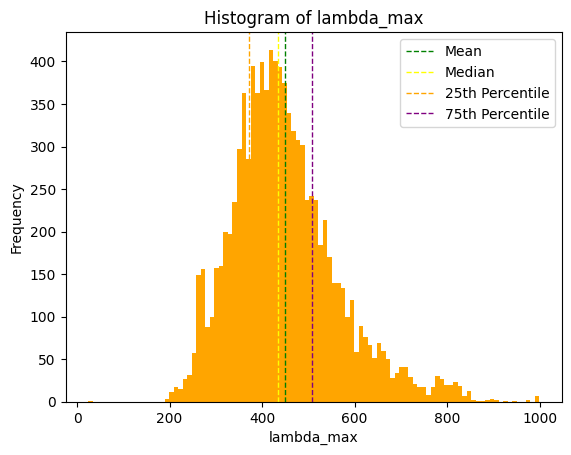

Mean = 448.60
Median = 434.00
Standard Deviation = 115.01
Minimum = 24.00
Maximum = 999.00
25th Percentile = 371.00
75th Percentile = 509.00
Interquartile Range = 138.00


In [5]:
analyzer = TargetAnalizer(df)
summary = analyzer.continuous_features('lambda_max', n_bins = 100, color_hex="#FFA500", alpha_value = 1)

In [6]:
activity_func = lambda x: 1 if 500 <= x <= 850 else 0
df_copy = df.copy()
df_copy.loc[:, 'activity'] = df_copy['lambda_max'].apply(activity_func)
df = df_copy
df = df.reset_index(drop=True)
df

,SMILES,lambda_max,activity
0,CC(C)C1=CC=CC(C(C)C)=C1N1C=C[N]2=C1C1=C(C=CC=C...,359,0
1,CC12[C]3(C)=[C]4(C)[C]5(C)=[C]1(C)[Ir]2345(C#[...,380,0
2,CC1=CC=C2C3=CC=CC=[N]3[Ir+3]345([C-]2=C1)[C-]1...,272,0
3,F[Ir](F)(F)(F)(F)F,829,1
4,FC1=CC2=C(C3=CC=CC=[N]3[Ir]2234C5=C(C6=CC=CC=[...,356,0
...,...,...,...
9778,CCCCN1C=CN2[C]1[Ru++]1345[C]6N(CCCC)C=CN6C6=CC...,434,0
9779,C1C2=CC=CC=[N]2[Ru++]2345[N]6=CC=CC=C6C6=CC=CC...,425,0
9780,[O-]C(=O)C1=CC2=[N]3C(=C1)C1=[N](C=CC=C1)[Ru++...,485,0
9781,CC1=CC2=[N](C=C1)[Ru++]([Cl-])([Cl-])(C#[O])(C...,362,0


In [7]:
df.to_csv("dforiginal_for_PCA.csv", index=False)

In [8]:
lamnda_distr = df.lambda_max

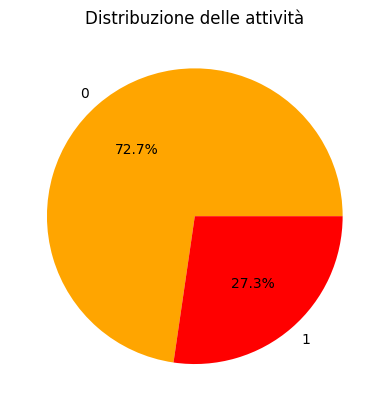

Numero di 1 nella colonna 'activity': 2671
Numero di 0 nella colonna 'activity': 7112
Percentuale di 1 rispetto al totale: 27.30246345701727 %
Percentuale di 0 rispetto al totale: 72.69753654298272 %


In [9]:
analyzer = TargetAnalizer(df)
summary = analyzer.categorical_features('activity')

In [10]:
cd PCA_descr

C:\Users\vince\Dropbox\MachineLearning\lambda_max_classification\PCA_descr


In [11]:
molecular = Molecular()
smiles_list = df.SMILES
molecules, problematic = molecular.load_molecules(smiles_list)
molecules_list = [molecular.set_dative_bonds(m) for m in molecules]
print(len(molecules_list),"molecules were converted")

9783 molecules were loaded
0 molecules get error
9783 molecules were converted


In [12]:
smiles_list.to_csv("smiles_list.smi", index=False)

In [13]:
dataframes = []
atomcent = molecular.load_Alvadesc(descr="atomcent", target_col=df["activity"], scaler=False)
dataframes.append(atomcent)
atompairs = molecular.load_Alvadesc(descr="atompairs", target_col=df["activity"], scaler=False)
dataframes.append(atompairs)
cats2d = molecular.load_Alvadesc(descr="cats2d", target_col=df["activity"], scaler=False)
dataframes.append(cats2d)
fgroup = molecular.load_Alvadesc(descr="fgroup", target_col=df["activity"], scaler=False)
dataframes.append(fgroup)
ring = molecular.load_Alvadesc(descr="ring", target_col=df["activity"], scaler=False)
dataframes.append(ring)
walkpath = molecular.load_Alvadesc(descr="walkpath", target_col=df["activity"], scaler=False)
dataframes.append(walkpath)

In [14]:
for dataf in dataframes:
    dataf.dropna(axis=1, how='all', inplace=True)
    pca = PCA(n_components=3)
    pca.fit(dataf)
    
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance explained by first two PCs: {explained_variance[0]+explained_variance[1]+explained_variance[2] }")

Variance explained by first two PCs: 0.8303723340142694
Variance explained by first two PCs: 0.7911445324476274
Variance explained by first two PCs: 0.8524293023316493
Variance explained by first two PCs: 0.8550306755016852
Variance explained by first two PCs: 0.8141582630880628
Variance explained by first two PCs: 0.9297395543987831


In [15]:
walkpath

,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,...,piPC09,piPC10,TWC,TPC,piID,PCR,PCD,CID,BID,activity
0,4.406719,6.056784,7.034388,8.057377,9.087608,10.141047,11.198749,12.271640,13.346490,14.432271,...,9.906218,10.435264,14.846626,11.725938,18.174226,1.549917,6.448288,4.995301,4.265253,0
1,2.995732,4.976734,6.300786,7.636752,8.971194,10.308186,11.644103,12.980821,14.317091,15.653649,...,0.000000,0.000000,15.958492,6.908755,7.907284,1.144531,0.998529,3.431590,2.818005,0
2,3.891820,5.556828,6.563856,7.621195,8.687611,9.775597,10.864120,11.963026,13.059502,14.162050,...,9.145588,9.575053,14.566659,9.746249,14.320875,1.469373,4.574626,4.462953,3.721039,0
3,1.945910,3.761200,4.290459,5.533389,6.070738,7.321850,7.860571,9.113058,9.652009,10.904726,...,0.000000,0.000000,11.338239,3.367296,3.367296,1.000000,0.000000,2.561056,2.193420,1
4,3.951244,5.624018,6.629363,7.689371,8.753213,9.842197,10.929762,12.029508,13.126469,14.230023,...,9.469592,9.920345,14.634223,9.904387,14.724457,1.486660,4.820070,4.524660,3.790828,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9778,4.077537,5.726848,6.734592,7.801800,8.878637,9.986771,11.089760,12.211543,13.324045,14.449757,...,9.005405,9.426419,14.843890,11.465823,14.732294,1.284888,3.266471,4.658613,3.917220,0
9779,3.784190,5.459586,6.493754,7.571988,8.659907,9.765891,10.871403,11.985582,13.096863,14.213277,...,8.895219,9.284427,14.610802,9.908326,14.045507,1.417546,4.137181,4.345540,3.593078,0
9780,3.970292,5.645447,6.660575,7.725330,8.798002,9.894901,10.990516,12.100006,13.204903,14.319078,...,9.880679,10.380870,14.718384,11.069338,16.486197,1.489357,5.416859,4.538929,3.790689,0
9781,3.258097,4.934474,5.872118,6.898715,7.872836,8.913147,9.901636,10.947380,11.943662,12.991181,...,7.351800,7.564757,13.430899,7.188413,9.630234,1.339689,2.441821,3.851915,3.192126,0


In [16]:
features = walkpath.iloc[:,:-1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

pca_df['activity'] = walkpath['activity']
pca_df

,PC1,PC2,PC3,activity
0,-5.523287,-0.838825,-0.131480,0
1,5.120190,9.399175,3.654233,0
2,-1.289887,0.247952,-0.973324,0
3,29.380180,1.647523,3.361919,1
4,-2.067552,0.083506,-0.996433,0
...,...,...,...,...
9778,-2.570653,0.878520,-0.515715,0
9779,-0.603242,0.827002,-1.150206,0
9780,-2.831181,-0.011929,-1.445147,0
9781,6.585578,0.562282,-1.118288,0


In [17]:
orange_samples = pca_df.loc[pca_df["activity"] == 0]
red_samples = pca_df.loc[pca_df["activity"] == 1]

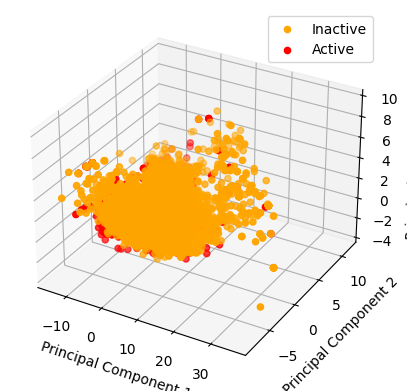

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(orange_samples['PC1'], orange_samples['PC2'], orange_samples['PC3'], c='orange', label='Inactive')
ax.scatter(red_samples['PC1'], red_samples['PC2'], red_samples['PC3'], c='red', label='Active')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.legend()

plt.show()

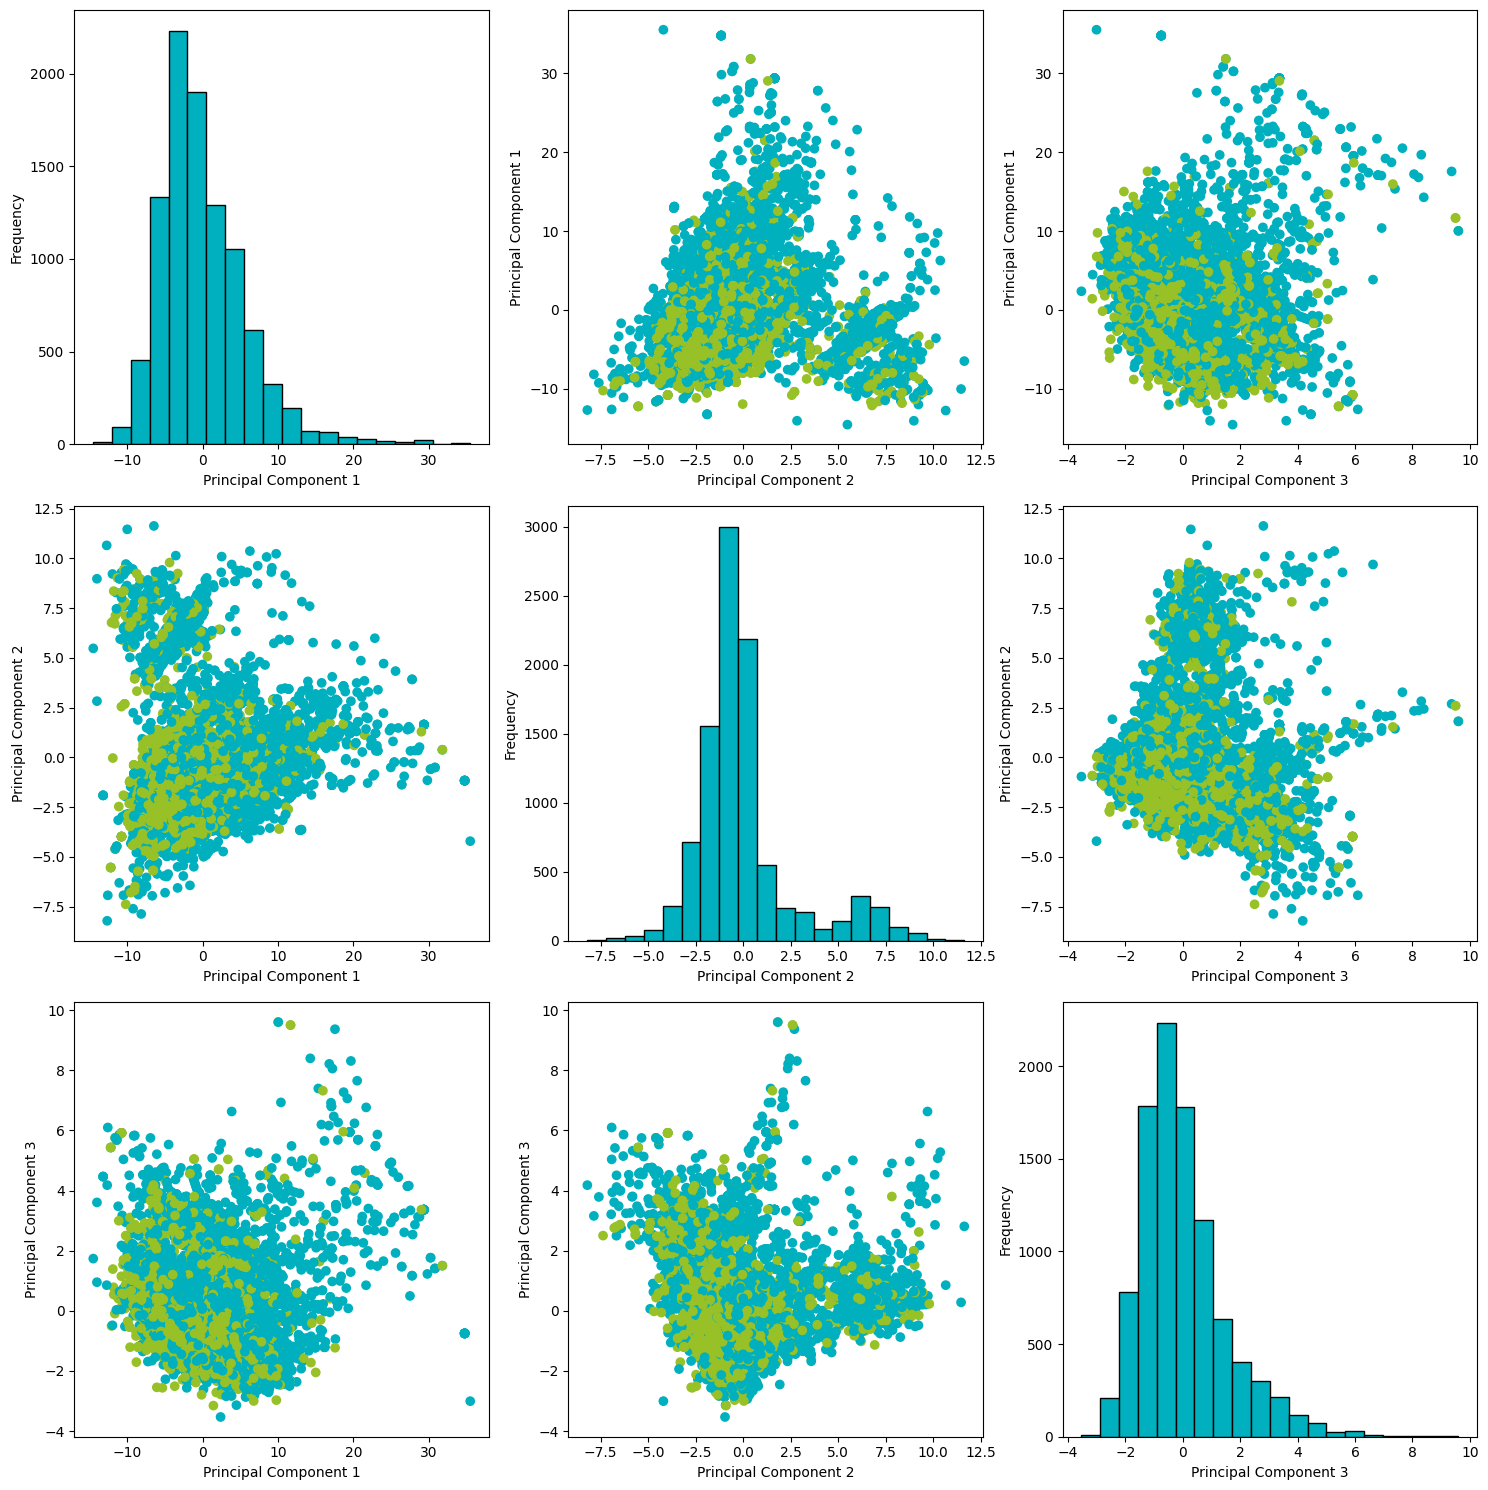

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i == j:
            ax.hist(pca_df[f'PC{i+1}'], bins=20, color='#00B0BE', edgecolor='black')
            ax.set_xlabel(f'Principal Component {i+1}')
            ax.set_ylabel('Frequency')
        else:
            colors = pca_df['activity'].map({0: '#00B0BE', 1: '#98C127'})
            ax.scatter(pca_df[f'PC{j+1}'], pca_df[f'PC{i+1}'], c=colors)
            ax.set_xlabel(f'Principal Component {j+1}')
            ax.set_ylabel(f'Principal Component {i+1}')

plt.tight_layout()
plt.show()

In [20]:
pca_df_in = pca_df.loc[pca_df["activity"] == 0]

In [21]:
np.random.seed(42)
weights = np.ones(len(pca_df_in)) / len(pca_df_in)

num_samples = 3000

selected_indices = np.random.choice(len(pca_df_in), size=num_samples, replace=False, p=weights)

selected_samples = pca_df_in.iloc[selected_indices, :]
selected_samples

,PC1,PC2,PC3,activity
3240,5.957336,-2.517349,1.678280,0
9158,-2.096370,-0.399288,-1.147040,0
6330,6.155302,-0.035116,-2.592959,0
5218,-0.403446,-0.698181,-1.628406,0
1409,-4.195565,-1.249853,0.025950,0
...,...,...,...,...
518,-2.011466,0.086092,-1.068453,0
3553,0.537773,-1.625550,-0.558366,0
3839,5.548370,-0.640990,-1.519605,0
6280,3.420452,-0.202699,-1.697394,0


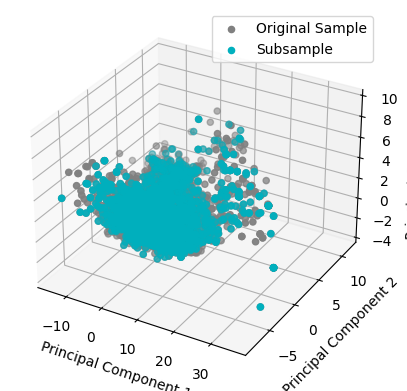

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df_in['PC1'], pca_df_in['PC2'], pca_df_in['PC3'], c='grey', label='Original Sample')
ax.scatter(selected_samples['PC1'], selected_samples['PC2'], selected_samples['PC3'], c='#00B0BE', label='Subsample')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

ax.legend()

plt.show()

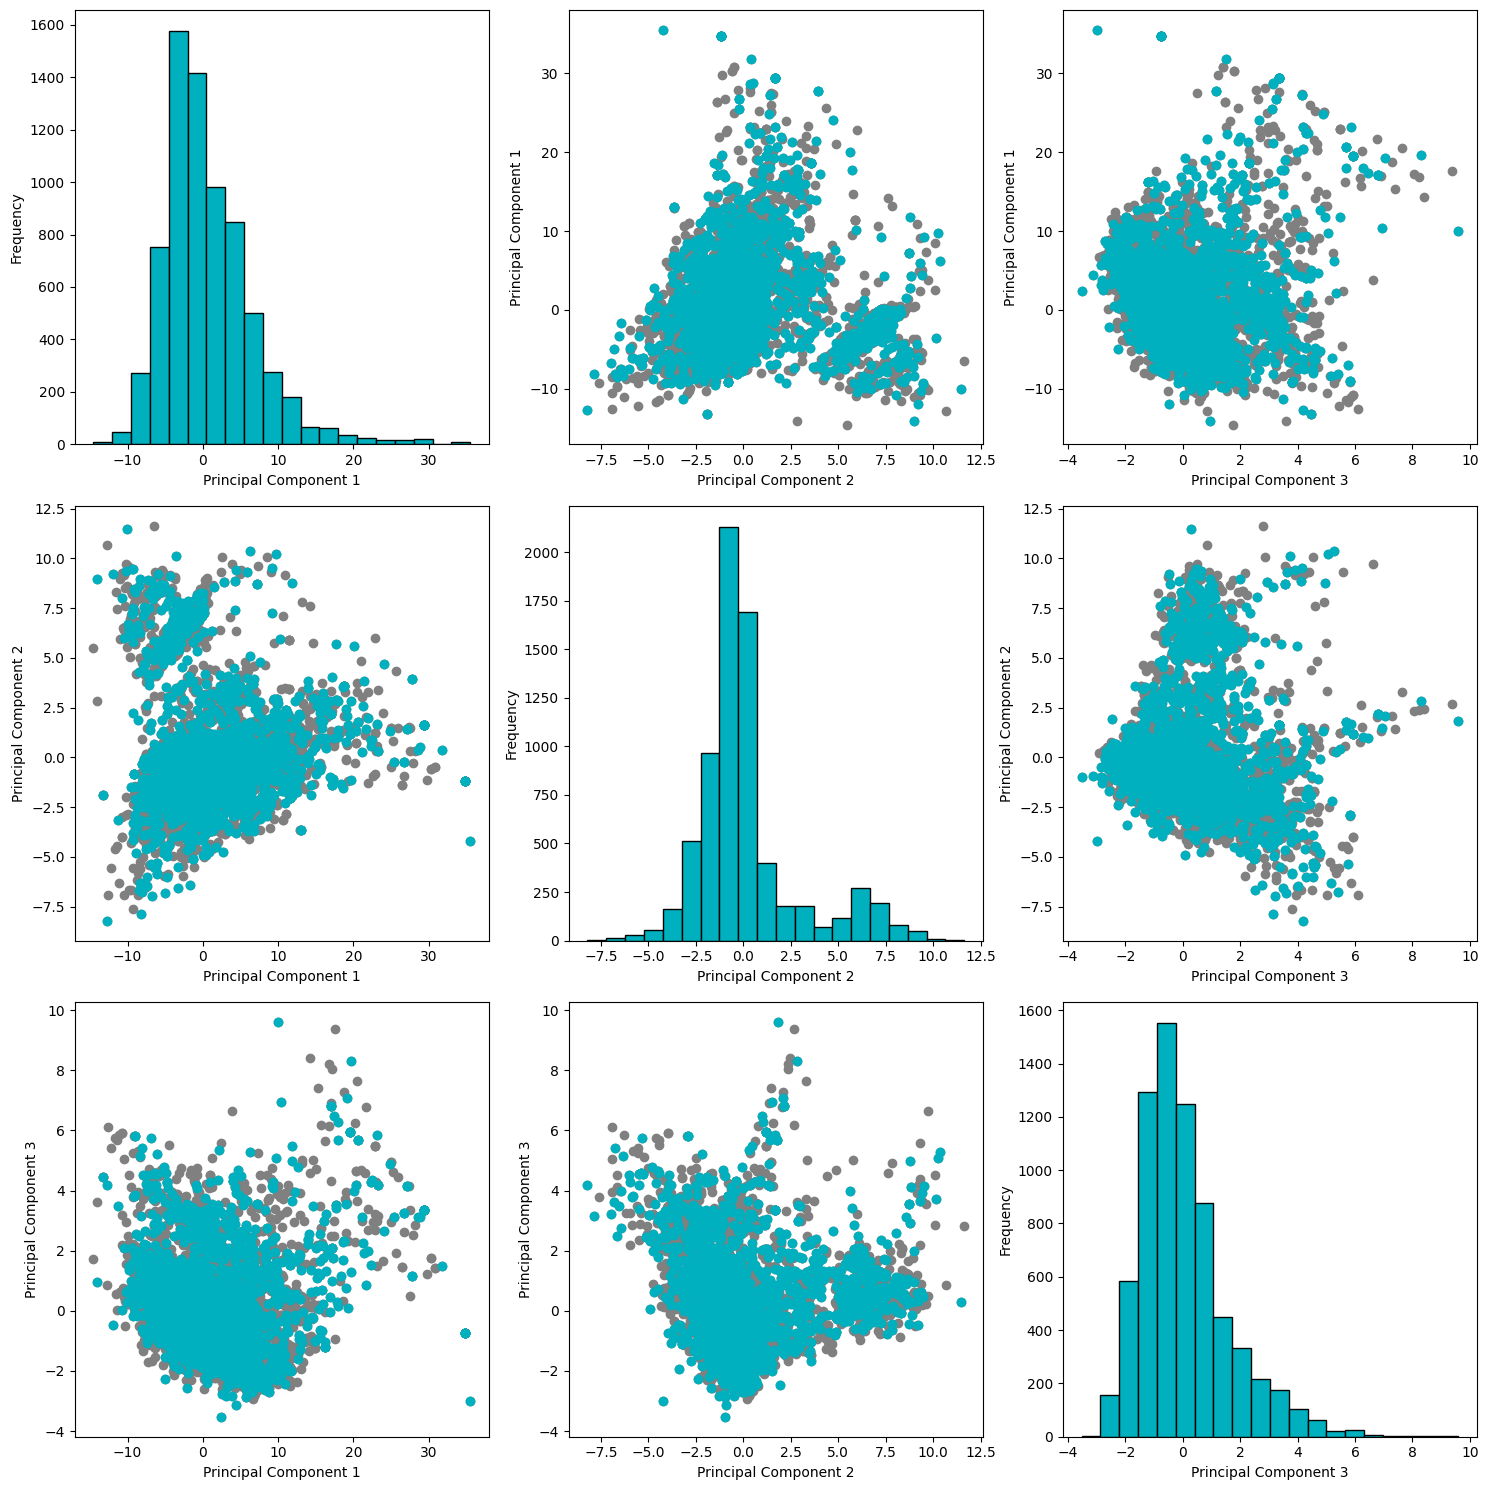

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i == j:
            ax.hist(pca_df_in[f'PC{i+1}'], bins=20, color='#00B0BE', edgecolor='black')
            ax.set_xlabel(f'Principal Component {i+1}')
            ax.set_ylabel('Frequency')
        else:
            ax.scatter(pca_df_in[f'PC{j+1}'], pca_df_in[f'PC{i+1}'], c="grey")
            ax.scatter(selected_samples[f'PC{j+1}'], selected_samples[f'PC{i+1}'], c="#00B0BE")
            ax.set_xlabel(f'Principal Component {j+1}')
            ax.set_ylabel(f'Principal Component {i+1}')

plt.tight_layout()
plt.show()


In [28]:
index_sel = selected_samples.index
df_inactive = df.loc[index_sel]
df_inactive = df_inactive.reset_index(drop=True)
df_active = df.loc[df['activity'] == 1]
df_active = df_active.reset_index(drop=True)
df_final = pd.concat([df_active,df_inactive],ignore_index=True)
df_final

,SMILES,lambda_max,activity
0,F[Ir](F)(F)(F)(F)F,829,1
1,CC1=CC=C(C=C1)C1=C2C=CC3=[N]2[Ir+3]24([Cl-])(C...,567,1
2,CCC1=C(CC)C2=CC3=[N]4C(=CC5=C(CC)C(CC)=C6C=C7C...,548,1
3,CC1=CC(C)=[O][Ir]234(O1)C1=C(C=CC=C1)C1=[N]2C=...,523,1
4,C[C@@]12[C]3(C)=[C]4(C)[C]5(C)=[C]1(C)[Ir]2345...,734,1
...,...,...,...
5666,CC1=CC2=[N](C=C1)[Ir]134(C5=CC=C(I)C=C25)C2=CC...,383,0
5667,C1C[P](C2=CC=CC=C2)(C2=CC=CC=C2)[Pt++]2([C-]#C...,398,0
5668,ClC1=CC=[C-](C=C1)[Pt++]1([C-]2=CC=C(Cl)C=C2)[...,450,0
5669,FC1=CC(F)=C2C3=[N](C=C(C=C3)C(F)(F)F)[Pt++]3([...,474,0


In [29]:
df_final = df_final.drop_duplicates()
df_final = df_final.reset_index(drop=True)

with open('indices_to_remove.pkl', 'rb') as file:
    indices_to_remove = pickle.load(file)
    
df_final = df_final.drop(indices_to_remove).reset_index(drop=True)
df_final

,SMILES,lambda_max,activity
0,CC1=CC=C(C=C1)C1=C2C=CC3=[N]2[Ir+3]24([Cl-])(C...,567,1
1,CCC1=C(CC)C2=CC3=[N]4C(=CC5=C(CC)C(CC)=C6C=C7C...,548,1
2,CC1=CC(C)=[O][Ir]234(O1)C1=C(C=CC=C1)C1=[N]2C=...,523,1
3,C[C@@]12[C]3(C)=[C]4(C)[C]5(C)=[C]1(C)[Ir]2345...,734,1
4,[Cl-][Ir+]12345[CH]6=[CH]1CC[CH]2=[CH]3CC6.C1=...,565,1
...,...,...,...
4635,CC1=CC2=[N](C=C1)[Ir]134(C5=CC=C(I)C=C25)C2=CC...,383,0
4636,C1C[P](C2=CC=CC=C2)(C2=CC=CC=C2)[Pt++]2([C-]#C...,398,0
4637,ClC1=CC=[C-](C=C1)[Pt++]1([C-]2=CC=C(Cl)C=C2)[...,450,0
4638,FC1=CC(F)=C2C3=[N](C=C(C=C3)C(F)(F)F)[Pt++]3([...,474,0


In [30]:
df_final.to_csv("smiles_final.csv",index=False)

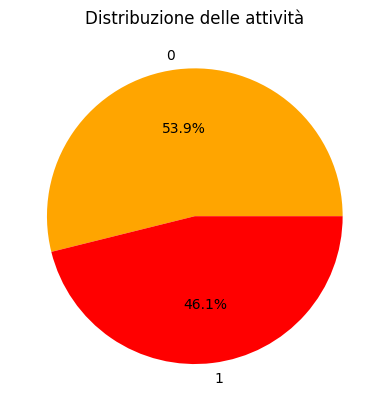

Numero di 1 nella colonna 'activity': 2140
Numero di 0 nella colonna 'activity': 2500
Percentuale di 1 rispetto al totale: 46.12068965517241 %
Percentuale di 0 rispetto al totale: 53.879310344827594 %


In [31]:
analyzer = TargetAnalizer(df_final)
summary = analyzer.categorical_features('activity')

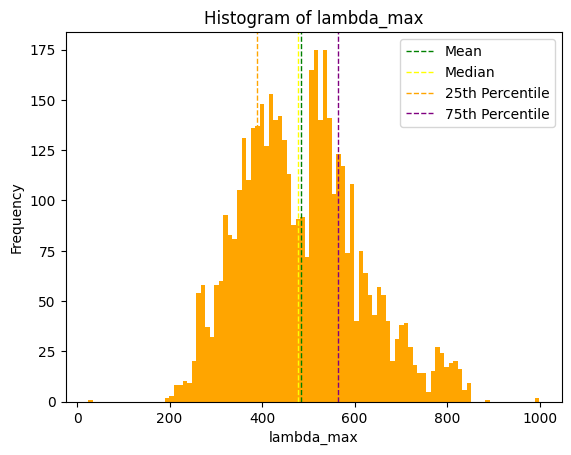

Mean = 484.82
Median = 478.00
Standard Deviation = 128.12
Minimum = 24.00
Maximum = 999.00
25th Percentile = 389.00
75th Percentile = 564.00
Interquartile Range = 175.00


In [32]:
analyzer = TargetAnalizer(df_final)
summary = analyzer.continuous_features('lambda_max', n_bins = 100, color_hex="#FFA500", alpha_value = 1)

In [33]:
smiles_list = df_final.SMILES
molecules, problematic = molecular.load_molecules(smiles_list)
molecules_list = [molecular.set_dative_bonds(m) for m in molecules]
print(len(molecules_list),"molecules were converted")

4640 molecules were loaded
0 molecules get error
4640 molecules were converted


In [34]:
ECFP1024_4X = molecular.generate_ECFP(molecules_list, max_size = 4, n_bits = 1024)
ECFP1024_6X = molecular.generate_ECFP(molecules_list, max_size = 6, n_bits = 1024)
ECFP2048_4X = molecular.generate_ECFP(molecules_list, max_size = 4, n_bits = 2048)
ECFP2048_6X = molecular.generate_ECFP(molecules_list, max_size = 6, n_bits = 2048)
ECFP4096_4X = molecular.generate_ECFP(molecules_list, max_size = 4, n_bits = 4096)
ECFP4096_6X = molecular.generate_ECFP(molecules_list, max_size = 6, n_bits = 4096)
ring = molecular.load_Alvadesc(descr = "ring_final", scaler = False)
Ring = molecular.load_Alvadesc(descr = "ring_final", target_col = df_final["activity"], scaler = False)
ECFP1024_4X = pd.concat([ECFP1024_4X,ring],axis=1)
ECFP1024_4 = pd.concat([ECFP1024_4X,df_final["activity"]],axis=1)
ECFP1024_6X = pd.concat([ECFP1024_6X,ring],axis=1)
ECFP1024_6 = pd.concat([ECFP1024_6X,df_final["activity"]],axis=1)
ECFP2048_4X = pd.concat([ECFP2048_4X,ring],axis=1)
ECFP2048_4 = pd.concat([ECFP2048_4X,df_final["activity"]],axis=1)
ECFP2048_6X = pd.concat([ECFP2048_6X,ring],axis=1)
ECFP2048_6 = pd.concat([ECFP2048_6X,df_final["activity"]],axis=1)
ECFP4096_4X = pd.concat([ECFP4096_4X,ring],axis=1)
ECFP4096_4 = pd.concat([ECFP4096_4X,df_final["activity"]],axis=1)
ECFP4096_6X = pd.concat([ECFP4096_6X,ring],axis=1)
ECFP4096_6 = pd.concat([ECFP4096_6X,df_final["activity"]],axis=1)

In [35]:
smiles_list.to_csv("smiles_final.smi",index=False)
#save files to calculate descriptors with alvadesc

In [36]:
CATS2D = molecular.load_Alvadesc(descr = "cats_final", target_col = df_final["activity"], scaler = False)
CATS2DX = CATS2D.drop(columns=["activity"])
AtomPairs = molecular.load_Alvadesc(descr = "AtomPairsU", target_col = df_final["activity"], scaler = False)
AtomPairsX = AtomPairs.drop(columns=["activity"])
FGroup = molecular.load_Alvadesc(descr = "FGroupU", target_col = df_final["activity"], scaler = False)
FGroupX = FGroup.drop(columns=["activity"])
MACCS = molecular.load_Alvadesc(descr = "MACCS_final", target_col = df_final["activity"], scaler = False)

comb1 = [AtomPairsX, CATS2DX]
comb2 = [ECFP4096_4X, AtomPairsX, CATS2DX]
comb3 = [FGroupX, CATS2DX]
comb4 = [FGroupX, ECFP1024_6X]
comb5 = [AtomPairsX, ECFP4096_6X]

Atom_CATS = pd.concat([pd.concat(comb1, axis=1), CATS2D["activity"]], axis=1)
ECFP_Atom_CATS = pd.concat([pd.concat(comb2, axis=1), CATS2D["activity"]], axis=1)
FGroup_CATS = pd.concat([pd.concat(comb3, axis=1), CATS2D["activity"]], axis=1)
FGroup_ECFP = pd.concat([pd.concat(comb4, axis=1), CATS2D["activity"]], axis=1)
Atom_ECFP = pd.concat([pd.concat(comb5, axis=1), CATS2D["activity"]], axis=1)

CATS2D_smiles = pd.concat([CATS2D,df_final["SMILES"]], axis=1)

In [37]:
list_of_datasets = {"ECFP1024_4": ECFP1024_4,
                    "ECFP1024_6": ECFP1024_6,
                    "ECFP2048_4": ECFP2048_4,
                    "ECFP2048_6": ECFP2048_6,
                    "ECFP4096_4": ECFP4096_4,
                    "ECFP4096_6": ECFP4096_6,
                    "CATS2D": CATS2D,
                    "AtomPairs": AtomPairs,
                    "FGroup": FGroup,
                    "Atom_CATS": Atom_CATS,
                    "ECFP_Atom_CATS": ECFP_Atom_CATS,
                    "FGroup_CATS": FGroup_CATS,
                    "FGroup_ECFP": FGroup_ECFP,
                    "Atom_ECFP": Atom_ECFP,
                    "MACCS":MACCS}

for dataset_name, df in list_of_datasets.items():
    if df.isnull().values.any():
        print(f"Il DataFrame '{dataset_name}' contiene valori NaN.")
    else:
        print(f"Il DataFrame '{dataset_name}' non contiene valori NaN.")

Il DataFrame 'ECFP1024_4' non contiene valori NaN.
Il DataFrame 'ECFP1024_6' non contiene valori NaN.
Il DataFrame 'ECFP2048_4' non contiene valori NaN.
Il DataFrame 'ECFP2048_6' non contiene valori NaN.
Il DataFrame 'ECFP4096_4' non contiene valori NaN.
Il DataFrame 'ECFP4096_6' non contiene valori NaN.
Il DataFrame 'CATS2D' non contiene valori NaN.
Il DataFrame 'AtomPairs' non contiene valori NaN.
Il DataFrame 'FGroup' non contiene valori NaN.
Il DataFrame 'Atom_CATS' non contiene valori NaN.
Il DataFrame 'ECFP_Atom_CATS' non contiene valori NaN.
Il DataFrame 'FGroup_CATS' non contiene valori NaN.
Il DataFrame 'FGroup_ECFP' non contiene valori NaN.
Il DataFrame 'Atom_ECFP' non contiene valori NaN.
Il DataFrame 'MACCS' non contiene valori NaN.


In [38]:
%%time
eng = FeaturesEngineering()

results = {}

for dataset_name, dataset in list_of_datasets.items():
    print(f"Processing dataset {dataset_name}...")
    X, y, X_val, y_val = eng.preprocess_split_classification(dataset, target_col='activity', test_size=0.2, corr_threshold=0.90)
    results[f'X_{dataset_name}'] = X
    results[f'y_{dataset_name}'] = y
    results[f'X_val_{dataset_name}'] = X_val
    results[f'y_val_{dataset_name}'] = y_val
    print("#############################\n")

Processing dataset ECFP1024_4...
Initial shape:  (4640, 1060)
#############################
train-test/val split data:
Training set: activity 1 = 46.12%, activity 0 = 53.88%, dimension = (3712, 1060)
Test set: activity 1 = 46.12%, activity 0 = 53.88%, dimension = (928, 1060)
Train set:  (3712, 1060)
Validation set:  (928, 1060)
#############################
Dimension after data preprocessing:
(3712, 105) (928, 105)
Percent of positive class: 46.1 %
#############################

Processing dataset ECFP1024_6...
Initial shape:  (4640, 1060)
#############################
train-test/val split data:
Training set: activity 1 = 46.12%, activity 0 = 53.88%, dimension = (3712, 1060)
Test set: activity 1 = 46.12%, activity 0 = 53.88%, dimension = (928, 1060)
Train set:  (3712, 1060)
Validation set:  (928, 1060)
#############################
Dimension after data preprocessing:
(3712, 128) (928, 128)
Percent of positive class: 46.1 %
#############################

Processing dataset ECFP2048_4...

In [39]:
for key, value in results.items():
    globals()[key] = value

In [40]:
data_list_Xy = [X_ECFP1024_4, X_ECFP1024_6, X_ECFP2048_4, X_ECFP2048_6, X_ECFP4096_4, X_ECFP4096_6,
                X_CATS2D, X_AtomPairs, X_FGroup,
                X_Atom_CATS, X_ECFP_Atom_CATS, X_FGroup_CATS, X_FGroup_ECFP, X_Atom_ECFP, X_MACCS]

data_val_Xy = [X_val_ECFP1024_4, X_val_ECFP1024_6, X_val_ECFP2048_4, X_val_ECFP2048_6, X_val_ECFP4096_4, X_val_ECFP4096_6,
                X_val_CATS2D, X_val_AtomPairs, X_val_FGroup,
                X_val_Atom_CATS, X_val_ECFP_Atom_CATS, X_val_FGroup_CATS, X_val_FGroup_ECFP, X_val_Atom_ECFP, X_val_MACCS]

y_train_list = y_ECFP1024_4
y_val_list = y_val_ECFP1024_4

counter = Counter(MACCS["activity"])
majority_class = counter[0]
minority_class = counter[1]
scale_pos_weight = majority_class / minority_class

models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', class_weight='balanced')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Support Vector Machines', SVC(random_state=42, class_weight='balanced')),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=42)),
    ('XGBClassifier', XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight))
]

In [41]:
bench = Benchmark()
results_list = []

for i, X in enumerate(data_list_Xy):
    print(f"{i} started")
    results_df = bench.train_models_classification(models, X, y_train_list, kfold_splits=10)
    print(f"{i} finished")
    results_list.append(results_df)

# Concatenate results into a single DataFrame
datasets_names = ["ECFP1024_4", "ECFP1024_6", "ECFP2048_4", "ECFP2048_6", "ECFP4096_4", "ECFP4096_6",
                  "CATS2D", "AtomPairs", "FGroup", "Atom_CATS", "ECFP_Atom_CATS", "FGroup_CATS",
                  "FGroup_ECFP", "Atom_ECFP", "MACCS"]

all_results_df_train = pd.concat(results_list, keys=datasets_names, names=["Dataset"])
pd.set_option('display.max_rows', None)

0 started
0 finished
1 started
1 finished
2 started
2 finished
3 started
3 finished
4 started
4 finished
5 started
5 finished
6 started
6 finished
7 started
7 finished
8 started
8 finished
9 started
9 finished
10 started
10 finished
11 started
11 finished
12 started
12 finished
13 started
13 finished
14 started
14 finished


In [42]:
all_results_df_train.round(2)

Model  Accuracy  Sensitivity  \
Dataset                                                                 
ECFP1024_4     0           Logistic Regression      0.76         0.73   
               1                 Decision Tree      0.81         0.81   
               2                 Random Forest      0.89         0.85   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.81         0.73   
               5                 XGBClassifier      0.89         0.87   
ECFP1024_6     0           Logistic Regression      0.77         0.73   
               1                 Decision Tree      0.80         0.80   
               2                 Random Forest      0.89         0.85   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.81         0.73   
               5                 XGBClassifier      0.88         0.87   
ECFP2048_4     0           Logistic Regression      0.77         0.73   
               1                 Decision Tree      0.81         0.81   
               2                 Random Forest      0.90         0.86   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.80         0.72   
               5                 XGBClassifier      0.89         0.88   
ECFP2048_6     0           Logistic Regression      0.76         0.73   
               1                 Decision Tree      0.81         0.81   
               2                 Random Forest      0.89         0.86   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.80         0.72   
               5                 XGBClassifier      0.88         0.87   
ECFP4096_4     0           Logistic Regression      0.76         0.72   
               1                 Decision Tree      0.83         0.82   
               2                 Random Forest      0.90         0.85   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.80         0.72   
               5                 XGBClassifier      0.89         0.88   
ECFP4096_6     0           Logistic Regression      0.76         0.72   
               1                 Decision Tree      0.82         0.81   
               2                 Random Forest      0.89         0.85   
               3       Support Vector Machines      0.69         0.47   
               4  Gradient Boosting Classifier      0.80         0.72   
               5                 XGBClassifier      0.88         0.87   
CATS2D         0           Logistic Regression      0.79         0.74   
               1                 Decision Tree      0.85         0.84   
               2                 Random Forest      0.93         0.90   
               3       Support Vector Machines      0.78         0.68   
               4  Gradient Boosting Classifier      0.84         0.78   
               5                 XGBClassifier      0.93         0.92   
AtomPairs      0           Logistic Regression      0.81         0.79   
               1                 Decision Tree      0.85         0.85   
               2                 Random Forest      0.91         0.89   
               3       Support Vector Machines      0.69         0.55   
               4  Gradient Boosting Classifier      0.85         0.79   
               5                 XGBClassifier      0.91         0.90   
FGroup         0           Logistic Regression      0.75         0.69   
               1                 Decision Tree      0.80         0.80   
               2                 Random Forest      0.87         0.84   
               3       Support Vector Machines      0.73         0.69   
               4  Gradient Boosting Classifier      0.78         0.71   
               5          

In [43]:
train_bench = all_results_df_train.round(2)
train_bench.to_csv("train_bench.csv")

In [44]:
%%time
results_list = []

for i in range(0, len(data_list_Xy)):
    print(i," started")
    X = data_list_Xy[i]
    X_val = data_val_Xy[i]
    results_df = bench.validate_models_classification(models, X, y_train_list, X_val, y_val_list, kfold_splits=10)
    print(i," finished")
    results_list.append(results_df)

all_results_df_test = pd.concat(results_list, keys=["ECFP1024_4", "ECFP1024_6", "ECFP2048_4", "ECFP2048_6", "ECFP4096_4", "ECFP4096_6",
                  "CATS2D", "AtomPairs", "FGroup", "Atom_CATS", "ECFP_Atom_CATS", "FGroup_CATS",
                  "FGroup_ECFP", "Atom_ECFP", "MACCS"], names=["Dataset"])

0  started
0  finished
1  started
1  finished
2  started
2  finished
3  started
3  finished
4  started
4  finished
5  started
5  finished
6  started
6  finished
7  started
7  finished
8  started
8  finished
9  started
9  finished
10  started
10  finished
11  started
11  finished
12  started
12  finished
13  started
13  finished
14  started
14  finished
CPU times: total: 5min 5s
Wall time: 3min 37s


In [45]:
test_bench = all_results_df_test.round(2)
test_bench.to_csv("test_bench.csv")
test_bench

Model  Accuracy  Sensitivity  \
Dataset                                                                 
ECFP1024_4     0           Logistic Regression      0.77         0.73   
               1                 Decision Tree      0.80         0.79   
               2                 Random Forest      0.89         0.84   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.84         0.76   
               5                 XGBClassifier      0.89         0.86   
ECFP1024_6     0           Logistic Regression      0.77         0.71   
               1                 Decision Tree      0.81         0.79   
               2                 Random Forest      0.89         0.84   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.81         0.71   
               5                 XGBClassifier      0.89         0.86   
ECFP2048_4     0           Logistic Regression      0.77         0.72   
               1                 Decision Tree      0.81         0.78   
               2                 Random Forest      0.90         0.86   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.82         0.72   
               5                 XGBClassifier      0.89         0.87   
ECFP2048_6     0           Logistic Regression      0.77         0.72   
               1                 Decision Tree      0.85         0.83   
               2                 Random Forest      0.90         0.86   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.82         0.73   
               5                 XGBClassifier      0.88         0.86   
ECFP4096_4     0           Logistic Regression      0.77         0.72   
               1                 Decision Tree      0.83         0.82   
               2                 Random Forest      0.90         0.85   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.82         0.72   
               5                 XGBClassifier      0.87         0.84   
ECFP4096_6     0           Logistic Regression      0.76         0.72   
               1                 Decision Tree      0.79         0.78   
               2                 Random Forest      0.90         0.85   
               3       Support Vector Machines      0.71         0.48   
               4  Gradient Boosting Classifier      0.80         0.72   
               5                 XGBClassifier      0.89         0.87   
CATS2D         0           Logistic Regression      0.78         0.71   
               1                 Decision Tree      0.86         0.85   
               2                 Random Forest      0.92         0.87   
               3       Support Vector Machines      0.80         0.67   
               4  Gradient Boosting Classifier      0.84         0.74   
               5                 XGBClassifier      0.92         0.90   
AtomPairs      0           Logistic Regression      0.82         0.80   
               1                 Decision Tree      0.86         0.85   
               2                 Random Forest      0.91         0.87   
               3       Support Vector Machines      0.71         0.56   
               4  Gradient Boosting Classifier      0.84         0.78   
               5                 XGBClassifier      0.91         0.88   
FGroup         0           Logistic Regression      0.74         0.67   
               1                 Decision Tree      0.80         0.79   
               2                 Random Forest      0.86         0.82   
               3       Support Vector Machines      0.75         0.71   
               4  Gradient Boosting Classifier      0.79         0.69   
               5          

In [41]:
print(X_ECFP1024_4.shape)
print(X_ECFP1024_6.shape)
print(X_ECFP2048_4.shape)
print(X_ECFP2048_6.shape)
print(X_ECFP4096_4.shape)
print(X_ECFP4096_6.shape)
print(X_CATS2D.shape)
print(X_AtomPairs.shape)
print(X_FGroup.shape)
print(X_Atom_CATS.shape)
print(X_ECFP_Atom_CATS.shape)
print(X_FGroup_CATS.shape)
print(X_FGroup_ECFP.shape)
print(X_Atom_ECFP.shape)
print(X_MACCS.shape)

(3712, 105)
(3712, 128)
(3712, 85)
(3712, 93)
(3712, 80)
(3712, 82)
(3712, 118)
(3712, 387)
(3712, 35)
(3712, 503)
(3712, 682)
(3712, 151)
(3712, 165)
(3712, 549)
(3712, 86)


In [42]:
X_Train = X_AtomPairs
y_Train = y_AtomPairs
X_Val = X_val_AtomPairs
y_Val = y_val_AtomPairs

In [43]:
model_XGB = [('XGBClassifier', XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight))]
bench = Benchmark()
selected_model_res1 = bench.train_models_classification(model_XGB, X_Train, y_Train)

selected_model_res2 = bench.validate_models_classification(model_XGB, X_Train, y_Train, X_Val, y_Val)
selected_model_res = pd.concat([selected_model_res1,selected_model_res2],ignore_index=True)
selected_model_res = selected_model_res.round(2)
selected_model_res

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,XGBClassifier,0.91,0.90,0.92,0.91,0.91
1,XGBClassifier,0.91,0.88,0.93,0.91,0.90


In [44]:
train_dtf = pd.concat([X_Train, y_Train],axis=1)
test_dtf = pd.concat([X_Val, y_Val],axis=1)

In [45]:
pd.set_option('display.max_rows', 10)

In [46]:
test_dtf["SMILES"] = CATS2D_smiles["SMILES"]
test_dtf

,T(N..N),T(N..O),T(N..S),T(N..P),T(N..F),T(N..Cl),T(N..Br),T(N..I),T(O..O),T(O..S),...,F10(O-F),F10(O-Cl),F10(O-X),F10(S-F),F10(P-F),F10(P-X),F10(F-F),F10(F-X),activity,SMILES
1532,30,0,0,0,288,0,0,0,0,0,...,0,0,0,0,0,0,9,0,1,FC(F)(F)C1=C2C=CC3=C(C4=[N]5C(C=C4)=C(C4=CC=C6...
1726,117,352,80,0,0,0,0,0,145,108,...,0,0,0,0,0,0,0,0,1,CCCNC(=O)C1=CC=[N]2C(=C1)C1=CC(=CC=[N]1[Ru++]2...
1414,6,22,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,1,[O]#C[Rh+]1(C#[O])[N-]2C(=CC(=C2N=C2C(=CC(C3=C...
2064,20,0,0,0,0,36,0,0,0,0,...,0,0,0,0,0,0,0,0,1,CN(C)C1=CC2=[N]3C(=C1)C1=CC=CC=[N]1[Ru]3(Cl)(C...
930,12,0,0,0,320,0,0,0,0,0,...,0,0,0,0,0,0,16,0,1,FC1=CC(F)=C(C(F)=C1)C1=C2C=CC3=[N]2[Pt++]24[N-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,32,44,0,0,0,32,0,0,10,0,...,0,0,0,0,0,0,0,0,0,NC(=O)C1=CC=C[N](=C1)[Pt++]([Cl-])([Cl-])[N]1=...
3749,6,17,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,[H][C@@]12CCC[N@@H]1[Ir+3]134([O-]C2=O)[C-]2=C...
2736,8,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CCCCC(CC)CN1C2=CC=CC3=C2[N]2=C1C1=C([O-][Pt++]...
2224,20,0,0,0,0,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[Cl-][Pt++]1([C-]2=C(C=C3C=CC=CC3=C2)C2=CC=CC=...


In [47]:
train_dtf["SMILES"] = CATS2D_smiles["SMILES"]
train_dtf

,T(N..N),T(N..O),T(N..S),T(N..P),T(N..F),T(N..Cl),T(N..Br),T(N..I),T(O..O),T(O..S),...,F10(O-F),F10(O-Cl),F10(O-X),F10(S-F),F10(P-F),F10(P-X),F10(F-F),F10(F-X),activity,SMILES
966,12,0,0,0,272,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,FC1=C(F)C(F)=C(C(F)=C1F)C1=C2C=CC3=[N]2[Pt++]2...
554,92,0,138,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,CN(C)C1=CC=C(C=C1)C1=CC(C2=CC=C(C=C2)C2=CC=CC3...
2122,18,126,60,0,0,0,0,0,150,228,...,0,0,0,0,0,0,0,0,1,[H][C@]1(CCCN1C1=[S][Ru+3]234([S-]1)[S-]C(=[S]...
192,54,0,0,0,156,44,0,0,0,0,...,0,0,0,0,0,0,0,0,1,C1(F)=C2[C-]3=C(C4=CC(C(C)(C)C)=CC=[N]4[Ir+3]3...
679,88,0,0,0,288,0,0,0,0,0,...,0,0,0,0,0,0,9,0,1,FC(F)(F)C1=NN2C(=C1)C1=[N](C=NC=C1)[Pt]21N2N=C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,0,0,2,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C[S]1CC2=CC=CC=[N]2[Pt++]1([Cl-])[Cl-]
3235,0,0,0,0,0,0,0,0,760,0,...,0,0,0,0,0,0,0,0,0,O[P@@]1([O-])O[P@](O)([O-])[Pt+3]234([Br-])[P@...
3270,20,31,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,CC(C)C1=CC=CC(C(C)C)=C1N1C2=CC=CC=C2[N]2=C1C1=...
3434,26,108,0,56,0,0,0,0,116,0,...,0,0,0,0,0,0,0,0,0,CCCC[P](CCCC)(CCCC)[Pt++]([C-]#CC1=CC=C(C=C1)C...


In [48]:
train_dtf.to_csv("train_final.csv", index=True)
test_dtf.to_csv("test_final.csv", index=True)

In [49]:
test_dtf["UV"] = df_final["lambda_max"]
train_dtf["UV"] = df_final["lambda_max"]

In [50]:
test_dtf

,T(N..N),T(N..O),T(N..S),T(N..P),T(N..F),T(N..Cl),T(N..Br),T(N..I),T(O..O),T(O..S),...,F10(O-Cl),F10(O-X),F10(S-F),F10(P-F),F10(P-X),F10(F-F),F10(F-X),activity,SMILES,UV
1532,30,0,0,0,288,0,0,0,0,0,...,0,0,0,0,0,9,0,1,FC(F)(F)C1=C2C=CC3=C(C4=[N]5C(C=C4)=C(C4=CC=C6...,703
1726,117,352,80,0,0,0,0,0,145,108,...,0,0,0,0,0,0,0,1,CCCNC(=O)C1=CC=[N]2C(=C1)C1=CC(=CC=[N]1[Ru++]2...,537
1414,6,22,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,1,[O]#C[Rh+]1(C#[O])[N-]2C(=CC(=C2N=C2C(=CC(C3=C...,633
2064,20,0,0,0,0,36,0,0,0,0,...,0,0,0,0,0,0,0,1,CN(C)C1=CC2=[N]3C(=C1)C1=CC=CC=[N]1[Ru]3(Cl)(C...,616
930,12,0,0,0,320,0,0,0,0,0,...,0,0,0,0,0,16,0,1,FC1=CC(F)=C(C(F)=C1)C1=C2C=CC3=[N]2[Pt++]24[N-...,539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,32,44,0,0,0,32,0,0,10,0,...,0,0,0,0,0,0,0,0,NC(=O)C1=CC=C[N](=C1)[Pt++]([Cl-])([Cl-])[N]1=...,268
3749,6,17,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,[H][C@@]12CCC[N@@H]1[Ir+3]134([O-]C2=O)[C-]2=C...,466
2736,8,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,CCCCC(CC)CN1C2=CC=CC3=C2[N]2=C1C1=C([O-][Pt++]...,411
2224,20,0,0,0,0,14,0,0,0,0,...,0,0,0,0,0,0,0,0,[Cl-][Pt++]1([C-]2=C(C=C3C=CC=CC3=C2)C2=CC=CC=...,413


In [51]:
train_dtf.to_csv("train_final_UV.csv", index=True)
test_dtf.to_csv("test_final_UV.csv", index=True)

In [52]:
k_values = [5, 10, 15]
kfold_results = []
for k in k_values:
    fold_results = bench.train_models_classification(model_XGB, X_Train, y_Train, kfold_splits=k)
    kfold_results.append(fold_results)
    
kfold_results_df = pd.concat(kfold_results, ignore_index=True)
kfold_results_df = kfold_results_df.round(2)
kfold_results_df

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,XGBClassifier,0.91,0.89,0.92,0.91,0.90
1,XGBClassifier,0.91,0.90,0.92,0.91,0.91
2,XGBClassifier,0.92,0.90,0.93,0.91,0.91


In [53]:
train_dtf = pd.concat([X_Train, y_Train],axis=1)
test_dtf = pd.concat([X_Val, y_Val],axis=1)
test_dtf["SMILES"] = df_final["SMILES"]
train_dtf["SMILES"] = df_final["SMILES"]
test_dtf["UV"] = df_final["lambda_max"]
train_dtf["UV"] = df_final["lambda_max"]

In [54]:
from sklearn.inspection import permutation_importance
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_Train, y_Train)

y_pred = xgb_classifier.predict(X_Val)

result = permutation_importance(xgb_classifier, X_Val, y_Val, n_repeats=10, random_state=42)

importance = result.importances_mean

feature_names = X_Train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance',ascending=False)
feature_importance_df_sorted

,Feature,Importance
39,B01(C-X),0.031573
116,F02(C-N),0.011746
156,F03(C-X),0.010668
123,F02(C-X),0.010237
93,F01(C-C),0.008190
...,...,...
249,F06(C-X),-0.003341
77,B07(C-X),-0.003341
51,B02(N-X),-0.003341
129,F02(N-Cl),-0.003556


In [55]:
feature_importance_df_sorted.to_csv("feat_importance_final.csv")

In [56]:
xgb_classifier.fit(X_Train, y_Train)
print(f"Baseline accuracy on test data: {xgb_classifier.score(X_Val, y_Val):.2}")

Baseline accuracy on test data: 0.9


k = 15: 100%|██████████████████████████████████████████████████████████████████████████| 70/70 [04:40<00:00,  4.01s/it]


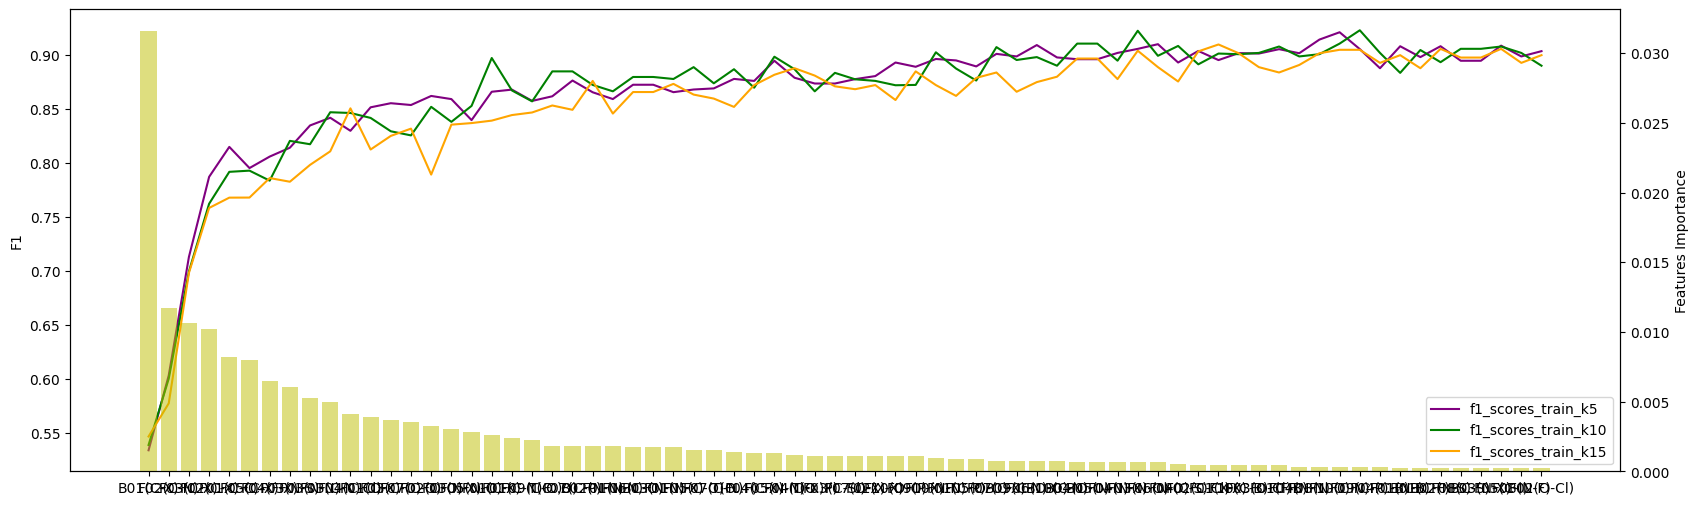

In [67]:
a, b, c = eng.rfe(xgb_classifier, X_Train[feature_importance_df_sorted.Feature.head(70)], y_Train, feature_importance_df_sorted.head(70), mean=False)

In [68]:
abc = pd.DataFrame({'a': a, 'b': b, 'c': c})
abc['c'].idxmax()

53

In [69]:
bench = Benchmark()
model_XGB = [('XGBClassifier', XGBClassifier(random_state=42))]
k_values=[5,10,15]
kfold_results = []
for k in k_values:
    fold_results = bench.train_models_classification(model_XGB, X_Train[feature_importance_df_sorted.Feature.head(53)], y_Train, kfold_splits=k)
    kfold_results.append(fold_results)
    
kfold_results_df = pd.concat(kfold_results, ignore_index=True)
kfold_results_df = kfold_results_df.round(2)
kfold_results_df

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,XGBClassifier,0.91,0.89,0.92,0.90,0.90
1,XGBClassifier,0.91,0.90,0.92,0.91,0.90
2,XGBClassifier,0.91,0.90,0.92,0.91,0.91


In [73]:
feature_importance_reset.iloc[45:55,:]

,Feature,Importance
45,B10(C-N),0.000754
46,B04(O-O),0.000647
47,B05(N-N),0.000647
48,F04(N-X),0.000647
49,F03(N-O),0.000647
50,F06(N-O),0.000647
51,F04(C-S),0.000539
52,F02(C-Cl),0.000431
53,F01(X-X),0.000431
54,F10(C-B),0.000431


In [70]:
feature_importance_reset = feature_importance_df_sorted.reset_index(drop=True)
abc_df = pd.concat([abc,feature_importance_reset.Feature.head(70)], axis = 1)
abc_df

,a,b,c,Feature
0,0.533557,0.538462,0.546341,B01(C-X)
1,0.603015,0.600000,0.577114,F02(C-N)
2,0.712934,0.699387,0.698113,F03(C-X)
3,0.787136,0.762195,0.758294,F02(C-X)
4,0.814925,0.791789,0.767857,F01(C-C)
...,...,...,...,...
65,0.894815,0.905882,0.897778,F08(C-S)
66,0.894815,0.905882,0.897778,B03(N-X)
67,0.908824,0.908012,0.905830,F05(C-I)
68,0.898810,0.902077,0.892857,F08(N-F)


In [71]:
abc_df.to_csv("rfe_xgbc.csv",index=False)

k = 15: 100%|██████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.65it/s]


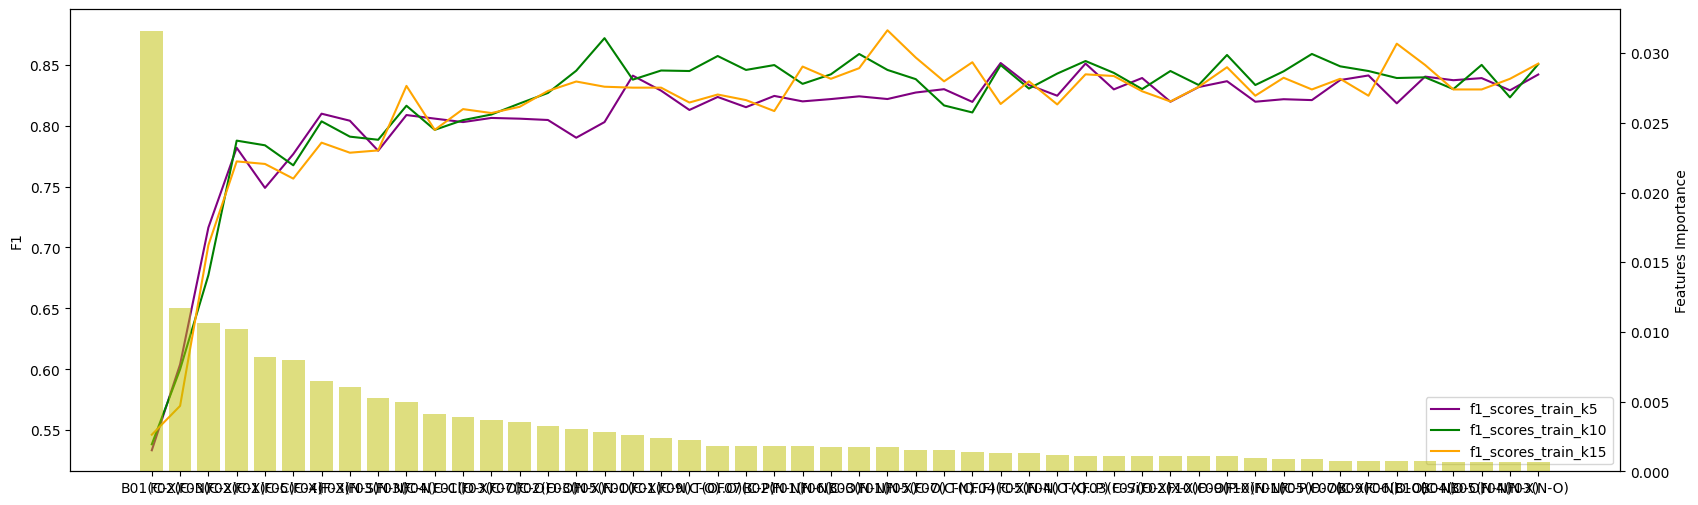

In [56]:
a, b, c = eng.rfe(DecisionTreeClassifier(random_state=42), X_Train[feature_importance_df_sorted.Feature.head(50)], y_Train, feature_importance_df_sorted.head(50), mean=False)

In [57]:
abc = pd.DataFrame({'a': a, 'b': b, 'c': c})
abc['c'].idxmax()

26

In [58]:
bench = Benchmark()
model_XGB = [('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42))]
k_values=[5,10,15]
kfold_results = []
for k in k_values:
    fold_results = bench.train_models_classification(model_XGB, X_Train[feature_importance_df_sorted.Feature.head(26)], y_Train, kfold_splits=k)
    kfold_results.append(fold_results)
    
kfold_results_df = pd.concat(kfold_results, ignore_index=True)
kfold_results_df = kfold_results_df.round(2)
kfold_results_df

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,DecisionTreeClassifier,0.84,0.83,0.84,0.82,0.83
1,DecisionTreeClassifier,0.85,0.85,0.86,0.84,0.84
2,DecisionTreeClassifier,0.85,0.84,0.86,0.84,0.84


In [53]:
%%time
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

model_XGB = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10],
    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}

random_search = RandomizedSearchCV(
    estimator=model_XGB,
    param_distributions=param_grid,
    n_iter=2000,  
    scoring='f1', 
    n_jobs=-1, 
    cv=10,  
    verbose=2,
    random_state=42 
)

random_search.fit(X_Train[feature_importance_df_sorted.Feature.head(43)], y_Train)

print("Best Parameters:", random_search.best_params_)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.6}
CPU times: total: 1min 15s
Wall time: 1h 9min 41s


best found in a previous random search : {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.31, 'gamma': 0, 'colsample_bytree': 1

In [57]:
from sklearn.metrics import precision_recall_curve
best_model = XGBClassifier(random_state=42,n_estimators= 400,max_depth=8, learning_rate=0.31)

best_model.fit(X_Train[feature_importance_df_sorted.Feature.head(43)], y_Train)

proba_test = best_model.predict_proba(X_Val[feature_importance_df_sorted.Feature.head(43)])[:, 1]

precision, recall, thresholds = precision_recall_curve(y_Val, proba_test)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1_score}")

proba_Ru = best_model.predict_proba(X_Val[feature_importance_df_sorted.Feature.head(43)])[:, 1]

pred_Ru = (proba_Ru >= best_threshold).astype(int)
test_dtf["pred"] = pred_Ru
test_dtf["proba"] = proba_Ru

Best Threshold: 0.22900623083114624
Best F1-Score: 0.906392694063927


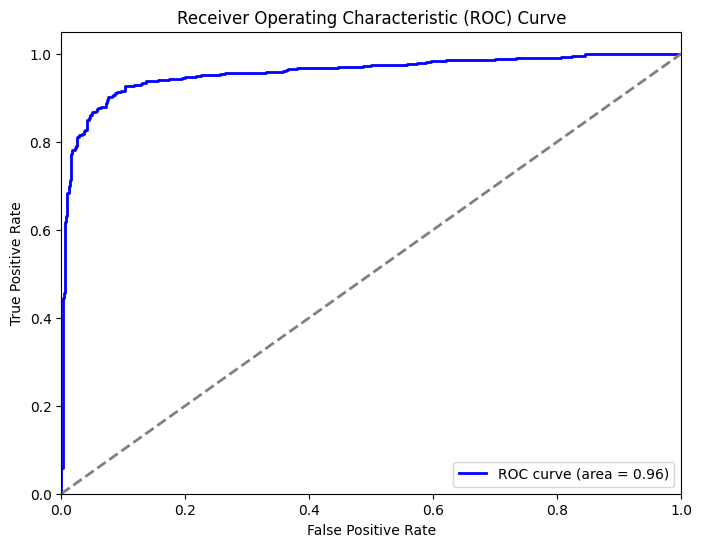

AUC-ROC: 0.9575514018691588


In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_thresholds = roc_curve(y_Val, proba_test)

auc_roc = roc_auc_score(y_Val, proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {auc_roc}")

In [60]:
tprfpr = pd.DataFrame({"fpr":fpr, "tpr":tpr})
tprfpr.to_csv("tprfpr.csv")

In [84]:
bench = Benchmark()
model_XGB = [('best', best_model)]
k_values=[5,10,15]
kfold_results = []
for k in k_values:
    fold_results = bench.train_models_classification(model_XGB, X_Train[feature_importance_df_sorted.Feature.head(49)], y_Train, kfold_splits=k)
    kfold_results.append(fold_results)
    
kfold_results_df = pd.concat(kfold_results, ignore_index=True)
kfold_results_df = kfold_results_df.round(2)
kfold_results_df

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,best,0.91,0.9,0.91,0.90,0.90
1,best,0.92,0.9,0.93,0.92,0.91
2,best,0.91,0.9,0.92,0.91,0.91


In [86]:
bench = Benchmark()
selected_model_res1 = bench.train_models_classification(model_XGB, X_Train[feature_importance_df_sorted.Feature.head(49)], y_Train)

selected_model_res2 = bench.validate_models_classification(model_XGB, X_Train[feature_importance_df_sorted.Feature.head(49)], y_Train, X_Val[feature_importance_df_sorted.Feature.head(49)], y_Val)
selected_model_res = pd.concat([selected_model_res1,selected_model_res2],ignore_index=True)
selected_model_res = selected_model_res.round(2)
selected_model_res

,Model,Accuracy,Sensitivity,Specificity,Precision,F1
0,best,0.92,0.90,0.93,0.92,0.91
1,best,0.91,0.89,0.93,0.92,0.90


In [87]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.31, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [89]:
test_dtf

,T(N..N),T(N..O),T(N..S),T(N..P),T(N..F),T(N..Cl),T(N..Br),T(N..I),T(O..O),T(O..S),...,F10(S-F),F10(P-F),F10(P-X),F10(F-F),F10(F-X),activity,SMILES,UV,pred,proba
1532,30,0,0,0,288,0,0,0,0,0,...,0,0,0,9,0,1,FC(F)(F)C1=C2C=CC3=C(C4=[N]5C(C=C4)=C(C4=CC=C6...,703,1,0.728150
1726,117,352,80,0,0,0,0,0,145,108,...,0,0,0,0,0,1,CCCNC(=O)C1=CC=[N]2C(=C1)C1=CC(=CC=[N]1[Ru++]2...,537,1,0.999200
1414,6,22,0,0,0,0,0,0,4,0,...,0,0,0,0,0,1,[O]#C[Rh+]1(C#[O])[N-]2C(=CC(=C2N=C2C(=CC(C3=C...,633,1,0.995931
2064,20,0,0,0,0,36,0,0,0,0,...,0,0,0,0,0,1,CN(C)C1=CC2=[N]3C(=C1)C1=CC=CC=[N]1[Ru]3(Cl)(C...,616,1,0.240524
930,12,0,0,0,320,0,0,0,0,0,...,0,0,0,16,0,1,FC1=CC(F)=C(C(F)=C1)C1=C2C=CC3=[N]2[Pt++]24[N-...,539,1,0.999986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,32,44,0,0,0,32,0,0,10,0,...,0,0,0,0,0,0,NC(=O)C1=CC=C[N](=C1)[Pt++]([Cl-])([Cl-])[N]1=...,268,0,0.000567
3749,6,17,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,[H][C@@]12CCC[N@@H]1[Ir+3]134([O-]C2=O)[C-]2=C...,466,0,0.000387
2736,8,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CCCCC(CC)CN1C2=CC=CC3=C2[N]2=C1C1=C([O-][Pt++]...,411,0,0.000890
2224,20,0,0,0,0,14,0,0,0,0,...,0,0,0,0,0,0,[Cl-][Pt++]1([C-]2=C(C=C3C=CC=CC3=C2)C2=CC=CC=...,413,0,0.004134


In [91]:
test_dtf.iloc[:,387:392]

,activity,SMILES,UV,pred,proba
1532,1,FC(F)(F)C1=C2C=CC3=C(C4=[N]5C(C=C4)=C(C4=CC=C6...,703,1,0.728150
1726,1,CCCNC(=O)C1=CC=[N]2C(=C1)C1=CC(=CC=[N]1[Ru++]2...,537,1,0.999200
1414,1,[O]#C[Rh+]1(C#[O])[N-]2C(=CC(=C2N=C2C(=CC(C3=C...,633,1,0.995931
2064,1,CN(C)C1=CC2=[N]3C(=C1)C1=CC=CC=[N]1[Ru]3(Cl)(C...,616,1,0.240524
930,1,FC1=CC(F)=C(C(F)=C1)C1=C2C=CC3=[N]2[Pt++]24[N-...,539,1,0.999986
...,...,...,...,...,...
4515,0,NC(=O)C1=CC=C[N](=C1)[Pt++]([Cl-])([Cl-])[N]1=...,268,0,0.000567
3749,0,[H][C@@]12CCC[N@@H]1[Ir+3]134([O-]C2=O)[C-]2=C...,466,0,0.000387
2736,0,CCCCC(CC)CN1C2=CC=CC3=C2[N]2=C1C1=C([O-][Pt++]...,411,0,0.000890
2224,0,[Cl-][Pt++]1([C-]2=C(C=C3C=CC=CC3=C2)C2=CC=CC=...,413,0,0.004134


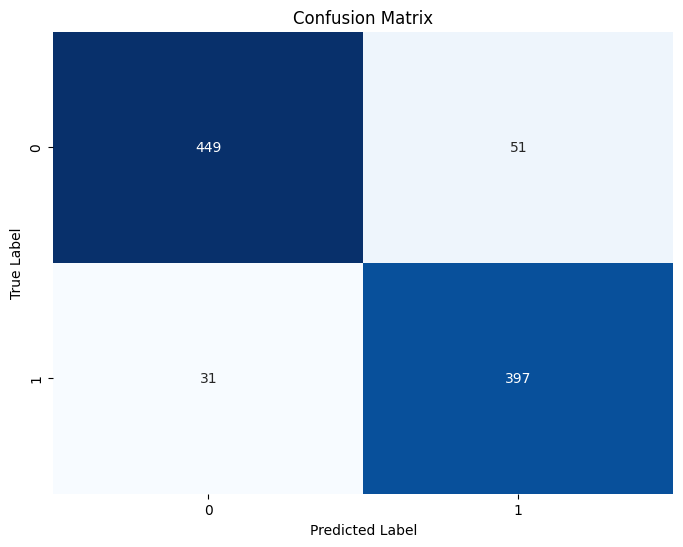

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcola la matrice di confusione
cm = confusion_matrix(test_dtf["activity"], test_dtf["pred"])

# Visualizza la matrice di confusione usando una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()